In [4]:
#Primero importamos las librerias necesarias
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import sympy

In [55]:
#Primero leemos todos los archivos txt
array_reposo = np.genfromtxt("Reposo_EKG.txt",delimiter="	",skip_header = 2)
array_respiracion=np.genfromtxt("/content/Respiración_EKG.txt",delimiter="	",skip_header = 2)
array_ejercicio=np.genfromtxt("/content/Ejercicio_EKG.txt",delimiter="	",skip_header = 2)

#Guardamos los valores de cada caso a un tipo de array
valores_reposo=array_reposo[:,-2]
valores_respiracion=array_respiracion[:,-2]
valores_ejercicio=array_ejercicio[:,-2]

#Determinamos la longitud de cada arreglo
cantidad_reposo=np.size(valores_reposo);
cantidad_respiracion=np.size(valores_respiracion);
cantidad_ejercicio=np.size(valores_ejercicio);

#Siendo la frecuencia de muestreo del BITalino de 1000 Hz
Fs=1000 #Hz
#Creamos los vectores de tiempo para cada caso
tiempo_reposo=np.arange(0,cantidad_reposo)
tiempo_reposo=tiempo_reposo/1000

tiempo_respiracion=np.arange(0,cantidad_respiracion)
tiempo_respiracion=tiempo_respiracion/1000

tiempo_ejercicio=np.arange(0,cantidad_ejercicio)
tiempo_ejercicio=tiempo_ejercicio/1000

#Convertimos los valores ADC a voltaje (mV)
valores_reposo=(((valores_reposo/1024)-0.5)*3.3)/(1100)
valores_reposo=valores_reposo*1000

valores_respiracion=(((valores_respiracion/1024)-0.5)*3.3)/(1100)
valores_respiracion=valores_respiracion*1000

valores_ejercicio=(((valores_ejercicio/1024)-0.5)*3.3)/(1100)
valores_ejercicio=valores_ejercicio*1000

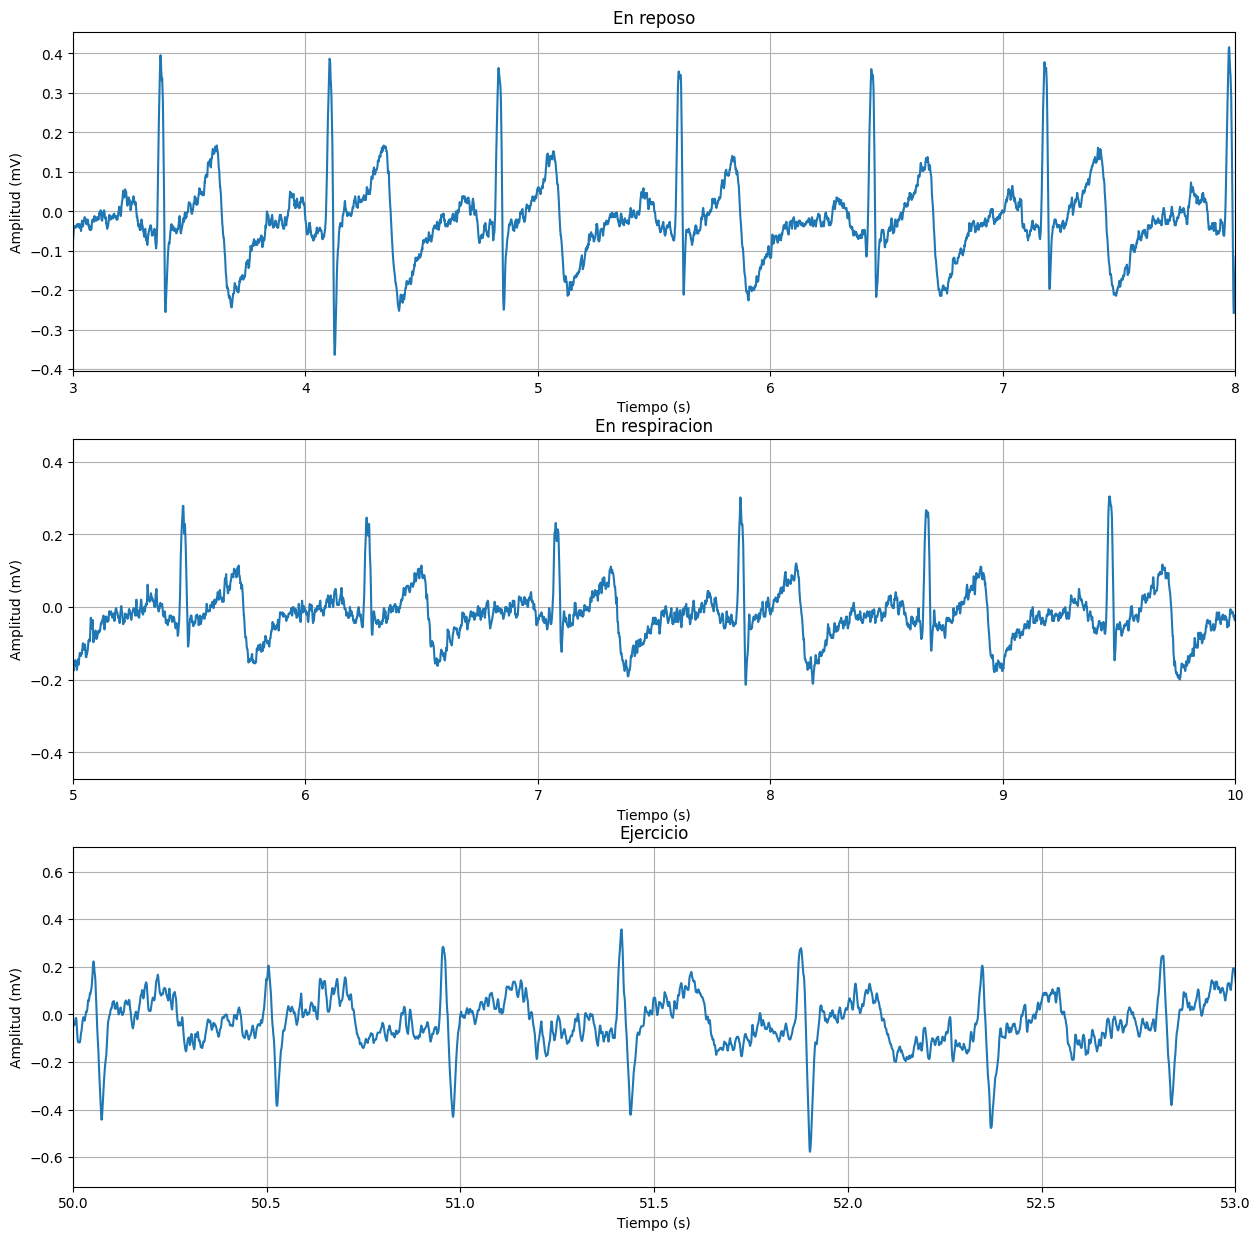

In [56]:
#Primero, mostramos todas las senales en crudo, es decir, sin filtrar
plt.figure(1,[15,15]);
plt.subplot(3,1,1);plt.plot(tiempo_reposo,valores_reposo);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud (mV)');plt.title('En reposo');plt.xlim([3,8]);plt.grid(True);

plt.subplot(3,1,2);plt.plot(tiempo_respiracion,valores_respiracion);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud (mV)');plt.title('En respiracion');plt.xlim([5,10]);plt.grid(True)
plt.subplot(3,1,3);plt.plot(tiempo_ejercicio,valores_ejercicio);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud (mV)');plt.title('Ejercicio');plt.xlim([50,53]);plt.grid(True)

(0.0, 200.0)

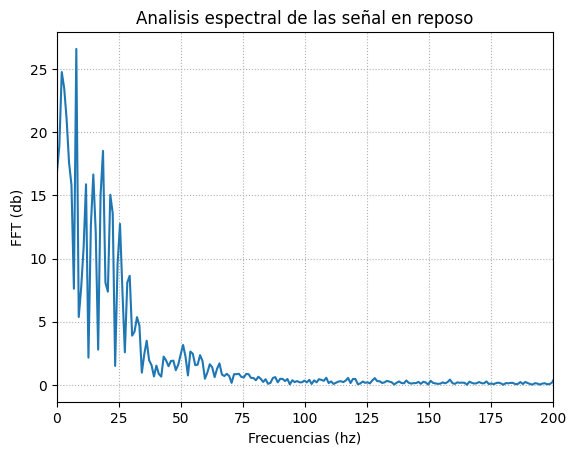

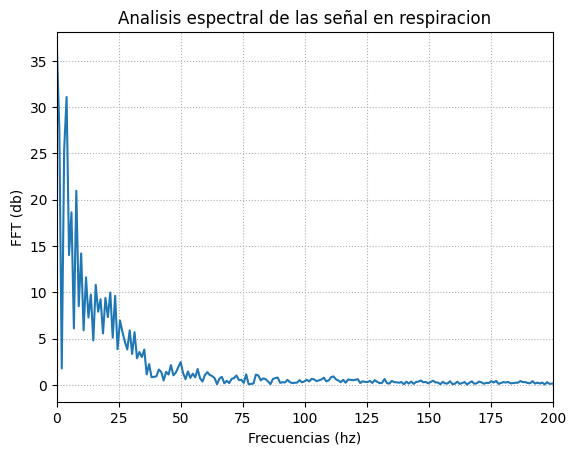

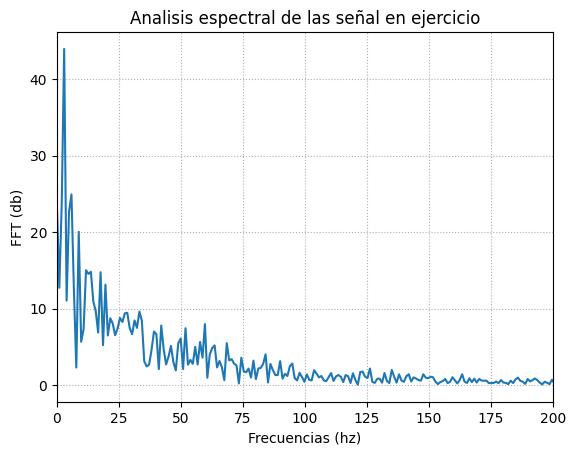

In [17]:
#Ahora analizamos todas las senales en frecuencia
Fs=1000 #Del bitalino
N=2**10 # 10 bits

#Calculamos la fft de cada senal
X_reposo = np.fft.fft(valores_reposo,N)
X_reposo = X_reposo[0:N//2]

X_respiracion = np.fft.fft(valores_respiracion,N)
X_respiracion = X_respiracion[0:N//2]

X_ejercicio = np.fft.fft(valores_ejercicio,N)
X_ejercicio = X_ejercicio[0:N//2]

mag_reposo = np.abs(X_reposo)
mag_respiracion = np.abs(X_respiracion)
mag_ejercicio = np.abs(X_ejercicio)

F = np.linspace(0,Fs/2,N//2)

#Now, we plot the spectrums, I put limits in the x axis for a better visualization of the frequencies
plt.figure()
plt.plot(F, mag_reposo)
plt.grid(linestyle=":")
plt.title("Analisis espectral de las señal en reposo")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.xlim([0,200])

plt.figure()
plt.plot(F, mag_respiracion)
plt.grid(linestyle=":")
plt.title("Analisis espectral de las señal en respiracion")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.xlim([0,200])

plt.figure()
plt.plot(F, mag_ejercicio)
plt.grid(linestyle=":")
plt.title("Analisis espectral de las señal en ejercicio")
plt.xlabel("Frecuencias (hz)")
plt.ylabel("FFT (db)")
plt.xlim([0,200])


In [51]:
#Disenando el filtro del ECG
wp=2*np.pi*30
ws=2*np.pi*50
#La frecuencia de muestreo fm es 1000Hz (BITalino)
N_ord, Wc= signal.buttord(wp, ws, gpass=3, gstop=40, analog=True) #gpass=loss in passband edge frecuencies, gstop= attenuation in stopband edge frecuencies
fc = np.round(Wc/(2*np.pi) ,2)

b,a = signal.butter(N_ord, Wc, 'lowpass', True, 'ba')


Text(0, 0.5, 'Magnitud (db)')

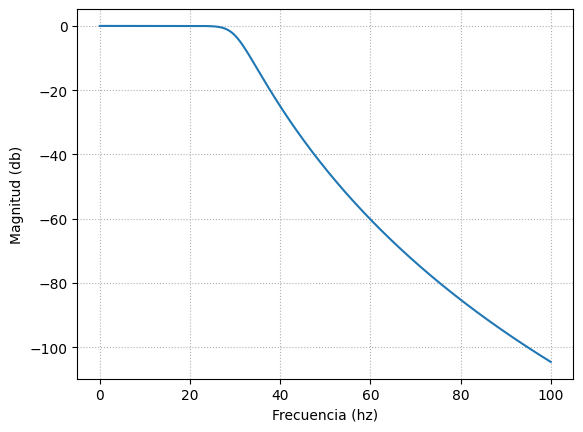

In [52]:
Fmax=100
F_freqs = np.linspace(0,Fmax,1000)
W_freqs = 2*np.pi*F_freqs  #Angular frecuences

W_freqs, H = signal.freqs(b,a,W_freqs)
Hm=np.abs(H)
plt.plot(F_freqs, 20 * np.log10(Hm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

Text(0, 0.5, 'Magnitud (db)')

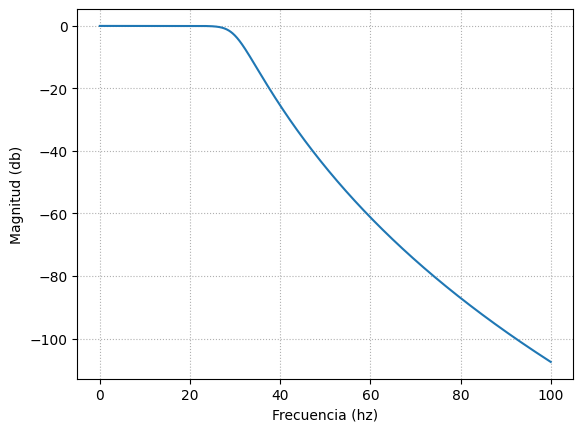

In [53]:
bd, ad = signal.bilinear(b,a,Fs)

Wz, Hd = signal.freqz(bd, ad, W_freqs/Fs)

Hdm = np.abs(Hd)
plt.plot(F_freqs, 20 * np.log10(Hdm))
plt.grid(linestyle=":")
plt.xlabel("Frecuencia (hz)")
plt.ylabel("Magnitud (db)")

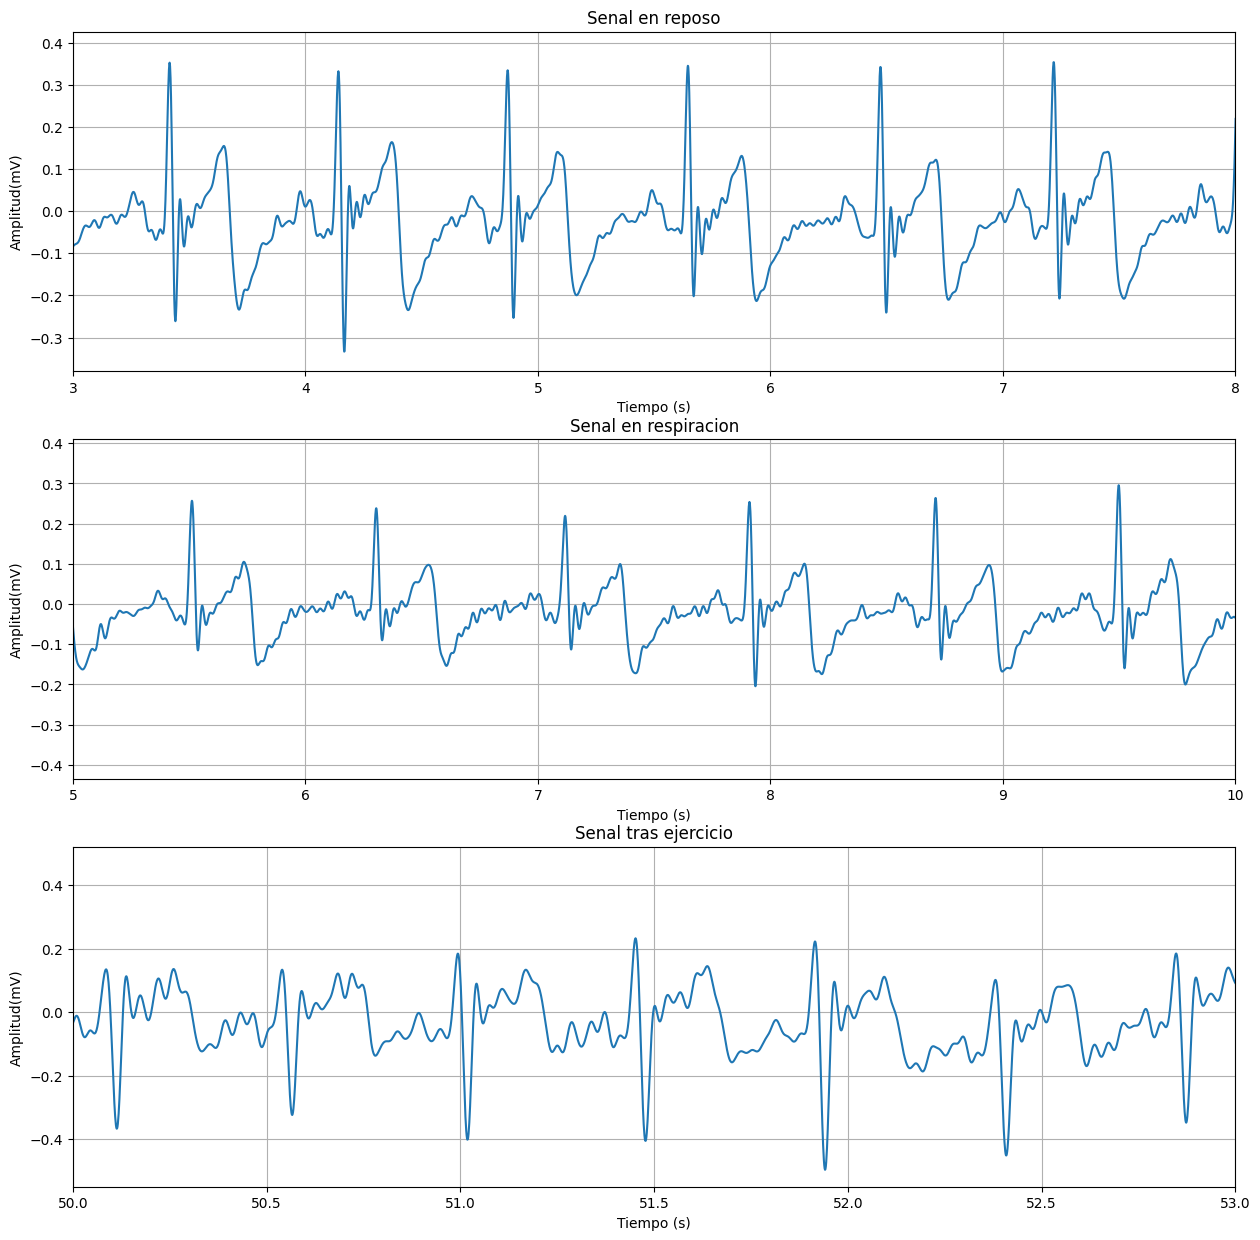

In [57]:
#Procedemos con el filtrado de la senal

y_reposo = signal.lfilter(bd,ad, valores_reposo)
y_respiracion = signal.lfilter(bd,ad, valores_respiracion)
y_ejercicio = signal.lfilter(bd,ad, valores_ejercicio)
plt.figure(3,[15,15])
plt.subplot(3,1,1)
plt.plot(tiempo_reposo,y_reposo);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud(mV)');plt.title('Senal en reposo');plt.xlim([3,8]);plt.grid(True)
plt.subplot(3,1,2)
plt.plot(tiempo_respiracion,y_respiracion);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud(mV)');plt.title('Senal en respiracion');plt.xlim([5,10]);plt.grid(True)
plt.subplot(3,1,3)
plt.plot(tiempo_ejercicio,y_ejercicio);plt.xlabel('Tiempo (s)');plt.ylabel('Amplitud(mV)');plt.title('Senal tras ejercicio');plt.xlim([50,53]);plt.grid(True)